# Machine Learning in Chess to Study Patterns in Chess Games


## Import Libraries


In [51]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings

# Avoid showing warnings to keep the notebook outputs clean.
filterwarnings("ignore")


## Set Up Seaborn Plots


In [52]:
sns.set_theme(context="talk", style="darkgrid")


## Load the Data


In [53]:
DATA_PATH = "/Users/isaac/Dropbox/Documents/University/Year 4/Project (ECM3401)/ChessDBs/lichess_db_standard_rated_2022"
# Check whether the DataFrame has been loaded correctly.
df = dd.read_parquet(DATA_PATH, engine="pyarrow")
print(f"Loaded {len(df)} Rated Blitz and Rated Rapid games from 2022.\n")
display(df)
display(df.head())


Loaded 40121728 Rated Blitz and Rated Rapid games from 2022.



,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
npartitions=96,,,,,,,,,,,,
,datetime64[ns],category[unknown],string,category[unknown],category[unknown],string,string,string,string,int16,int16,string
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
0,2022-01-01 00:00:11,Rated Rapid game,600+0,1-0,Normal,B00,"Nimzowitsch Defense: Scandinavian Variation, A...",shahzad97,mpasha98,1500,1205,https://lichess.org/UMMGcaGz
1,2022-01-01 00:00:11,Rated Blitz game,300+3,0-1,Normal,D00,Queen's Pawn Game: Mason Variation,nicolas_clos,pangma,1430,1412,https://lichess.org/yJI78ET0
2,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,E97,"King's Indian Defense: Orthodox Variation, Aro...",oyuka79,JUAN121,2422,2292,https://lichess.org/mrPOJU0W
3,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,C22,Center Game: Berger Variation,manoharkatwa,RigoBam,1241,1221,https://lichess.org/YJ1AIn03
4,2022-01-01 00:00:12,Rated Blitz game,300+0,0-1,Time forfeit,A40,Modern Defense,raffrantic1,Carly001,1044,1091,https://lichess.org/RATgKCCm


## Get Distribution of Player Ratings


In [54]:
# Merge the counts into one, as the player's side isn't important.
white_rating_count = df["WhiteElo"].value_counts().compute()
black_rating_count = df["BlackElo"].value_counts().compute()
rating_counts = (
    pd.concat([white_rating_count, black_rating_count], axis=1).fillna(0).astype(int)
)
rating_counts = rating_counts.sum(axis=1)
# Find the minimum and maximum player rating.
max_rating = rating_counts.index.max()
min_rating = rating_counts.index.min()
print(f"Maximum Player Rating: {max_rating}")
print(f"Minimum Player Rating: {min_rating}")

# Define the bin edges for player ratings from 600 (minimum in Lichess) to the
# maximum in intervals of 200.
bin_size = 200
rating_bins = np.array([i for i in range(600, max_rating + bin_size, bin_size)])
rating_counts.index = pd.cut(rating_counts.index, bins=rating_bins)
merged_rating_counts = rating_counts.groupby(level=0).sum()
display(merged_rating_counts)


Maximum Player Rating: 3485
Minimum Player Rating: 600


(600, 800]        687535
(800, 1000]      3156347
(1000, 1200]     7207254
(1200, 1400]    11272801
(1400, 1600]    14835190
(1600, 1800]    16155957
(1800, 2000]    14200749
(2000, 2200]     8550908
(2200, 2400]     3183947
(2400, 2600]      817814
(2600, 2800]      142142
(2800, 3000]       11622
(3000, 3200]         382
(3200, 3400]          42
(3400, 3600]           1
dtype: int64

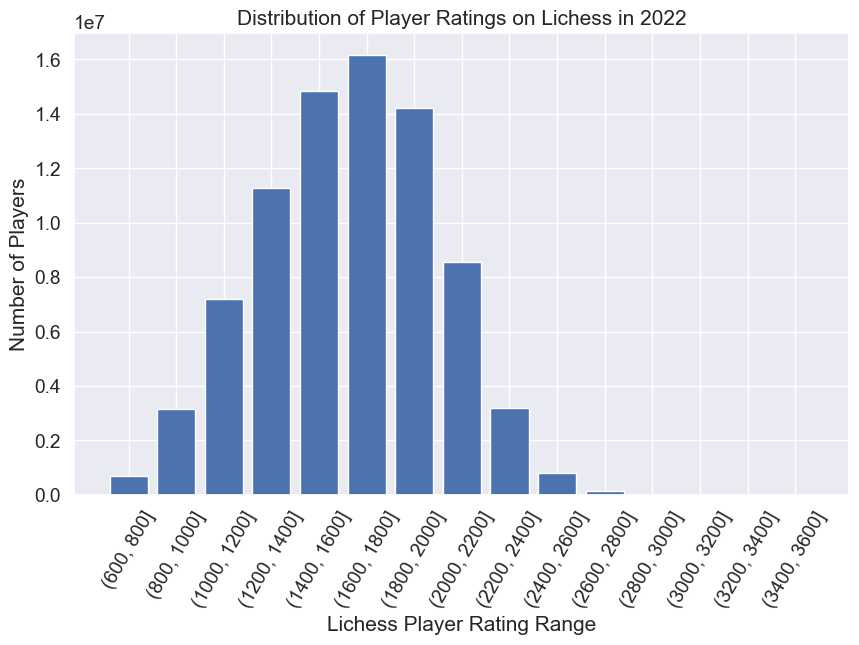

In [55]:
# Plot a graph to show the distribution of player ratings.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = merged_rating_counts.index.astype(str)
values = merged_rating_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Player Ratings on Lichess in 2022")
ax.set_xlabel("Lichess Player Rating Range")
ax.set_ylabel("Number of Players")
ax.set_xticklabels(indexes, rotation=60)
plt.show()


## Get Most Popular Openings by Category


### All Rated Players

In [56]:
# Find the most common ECO categories.
eco_categories = df["ECO"].str[0].value_counts().compute()
print("All Players:")
display(eco_categories)


All Players:


C    14070192
B    11256591
A     8653831
D     5478963
E      629352
?       32799
Name: ECO, dtype: Int64

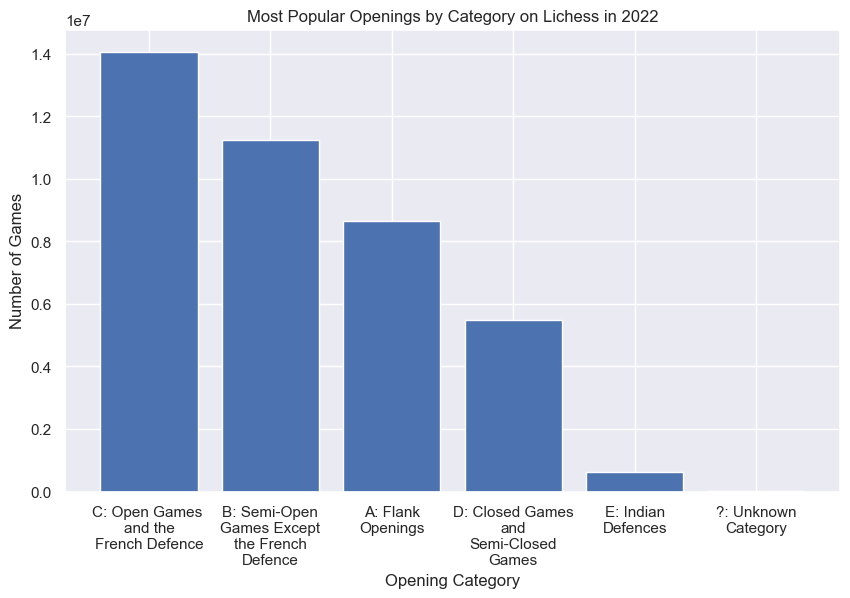

In [57]:
# Map each opening category to its type.
opening_category_map = {
    "A": "Flank\nOpenings",
    "B": "Semi-Open\nGames Except\nthe French\nDefence",
    "C": "Open Games \nand the\nFrench Defence",
    "D": "Closed Games\nand\nSemi-Closed\nGames",
    "E": "Indian\nDefences",
    "?": "Unknown\nCategory",
}

# Plot the number of games in each opening category.
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = eco_categories.index
values = eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### High Rated Players (Rating 2000+)


Players with Rating 2000 and Above:


B    2176694
A    1675378
C    1352678
D     902553
E     269989
?       5467
Name: ECO, dtype: Int64

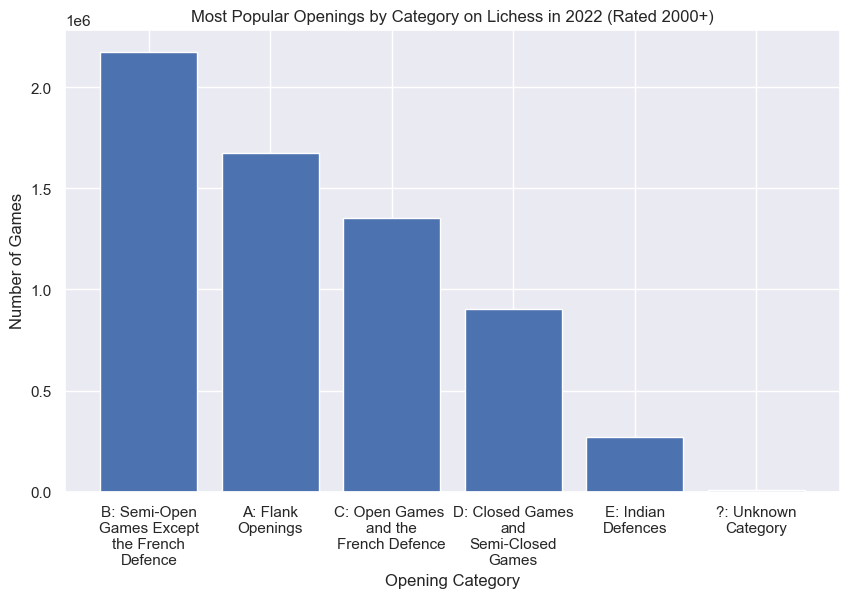

In [58]:
# Find the most common ECO categories for players rated 2000 and above.
high_rated_eco_categories = (
    df[df["WhiteElo"] >= 2000]["ECO"].str[0].value_counts().compute()
)
print("Players with Rating 2000 and Above:")
display(high_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = high_rated_eco_categories.index
values = high_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 2000+)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### Mid Rated Players (Rating 1201-1999)


Players with Rating 1201-1999:


C    10228118
B     7905666
A     5844439
D     3859371
E      346316
?       19882
Name: ECO, dtype: Int64

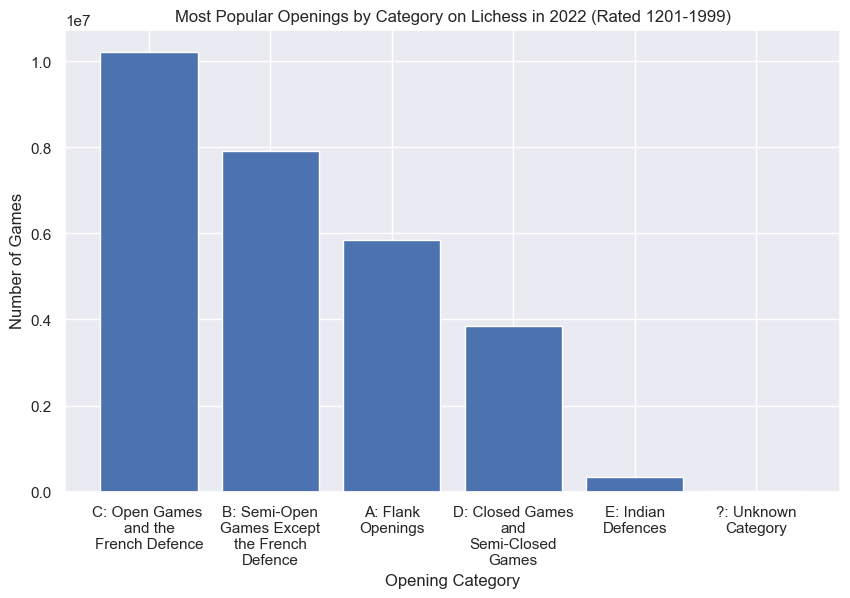

In [59]:
# Find the most common ECO categories for players rated 1401-1999.
mid_rated_eco_categories = (
    df[(df["WhiteElo"] >= 1201) & (df["WhiteElo"] <= 1999)]["ECO"]
    .str[0]
    .value_counts()
    .compute()
)
print("Players with Rating 1201-1999:")
display(mid_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = mid_rated_eco_categories.index
values = mid_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 1201-1999)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### Low Rated Players (Rating 1200 and Below)


Players with Rating 1200 and Below:


C    2489396
B    1174231
A    1134014
D     717039
E      13047
?       7450
Name: ECO, dtype: Int64

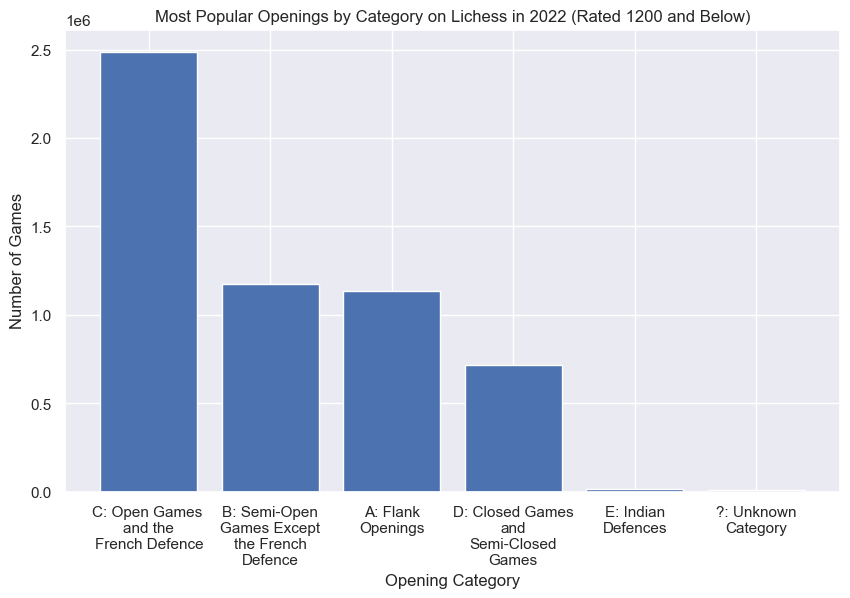

In [60]:
# Find the most common ECO categories for players rated 1400 and below.
low_rated_eco_categories = (
    df[df["WhiteElo"] <= 1200]["ECO"].str[0].value_counts().compute()
)
print("Players with Rating 1200 and Below:")
display(low_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = low_rated_eco_categories.index
values = low_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 1200 and Below)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()

## Get Most Popular Openings


### All Rated Players


In [61]:
# Group variations of the same opening together by splitting on the colon.
opening_groups = df["Opening"].str.split(":").str[0].value_counts().compute()
display(opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
top_15_openings = opening_groups[:15]
top_15_openings_proportion = top_15_openings.sum() / opening_groups.sum()
print(
    f"The top 15 openings account for {top_15_openings_proportion:.2%} of all "
    "games on Lichess in 2022."
)


Sicilian Defense        4492781
Queen's Pawn Game       3403077
French Defense          2266247
Scandinavian Defense    1979982
Italian Game            1868665
                         ...   
Venezolana Opening           29
Formation                    24
Dresden Opening              16
Amar Gambit                  15
Veresov Opening               9
Name: Opening, Length: 162, dtype: int64

The top 15 openings account for 63.68% of all games on Lichess in 2022.


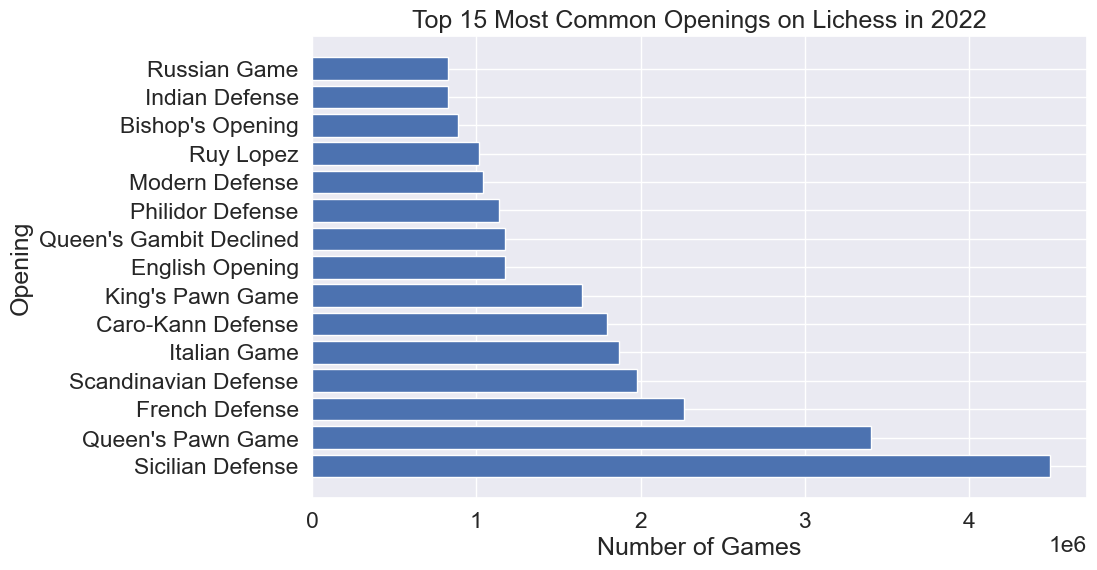

In [62]:
# Plot the top 15 most common openings.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = opening_groups.index[:15]
values = opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### High Rated Players (Rating 2000+)


Sicilian Defense      1080298
French Defense         429823
Queen's Pawn Game      409113
Caro-Kann Defense      376911
English Opening        311541
                       ...   
English Rat                 6
Amsterdam Attack            3
Venezolana Opening          2
Veresov Opening             2
Tayler Opening              1
Name: Opening, Length: 161, dtype: int64

The top 15 openings for players rated 2000+ account for 10.80% of all games on Lichess in 2022.


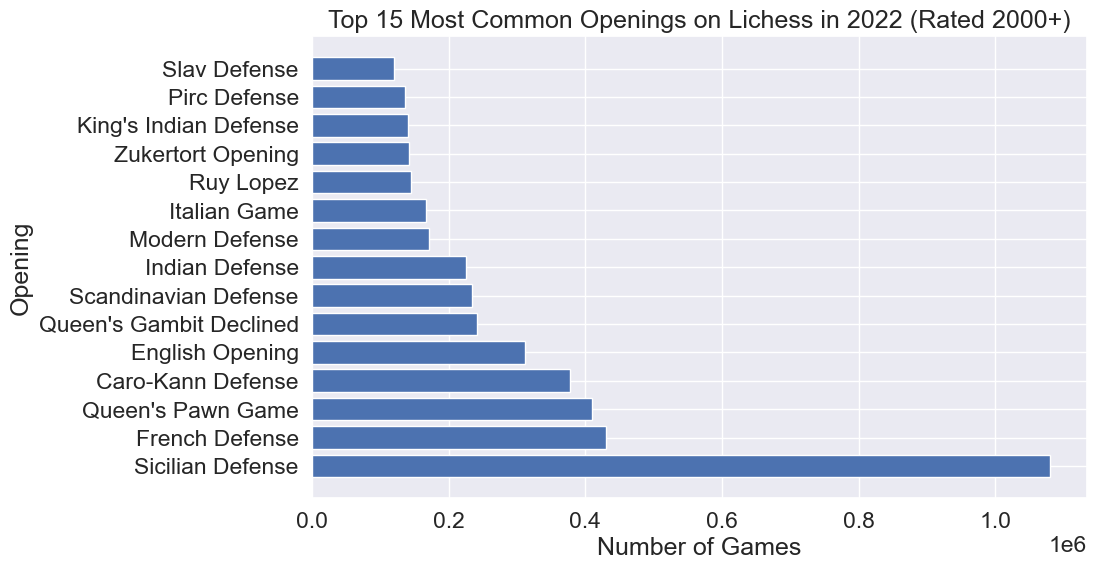

In [63]:
# Group variations of the same opening together by splitting on the colon.
high_rated_opening_groups = (
    df[df["WhiteElo"] >= 2000]["Opening"].str.split(":").str[0].value_counts().compute()
)
display(high_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
high_rated_top_15_openings = high_rated_opening_groups[:15]
high_rated_top_15_openings_proportion = (
    high_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 2000+ account for "
    f"{high_rated_top_15_openings_proportion:.2%} of all games on Lichess in "
    "2022."
)

# Plot the top 15 most common openings.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = high_rated_opening_groups.index[:15]
values = high_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 2000+)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Mid Rated Players (Rating 1201-1999)


Sicilian Defense                     3144923
Queen's Pawn Game                    2406971
French Defense                       1594203
Italian Game                         1442963
Scandinavian Defense                 1414562
                                      ...   
Blumenfeld Countergambit Accepted         16
Formation                                 12
Dresden Opening                            6
Veresov Opening                            5
Amar Gambit                                2
Name: Opening, Length: 162, dtype: int64

The top 15 openings for players rated 1201-1999 account for 45.47% of all games on Lichess in 2022.


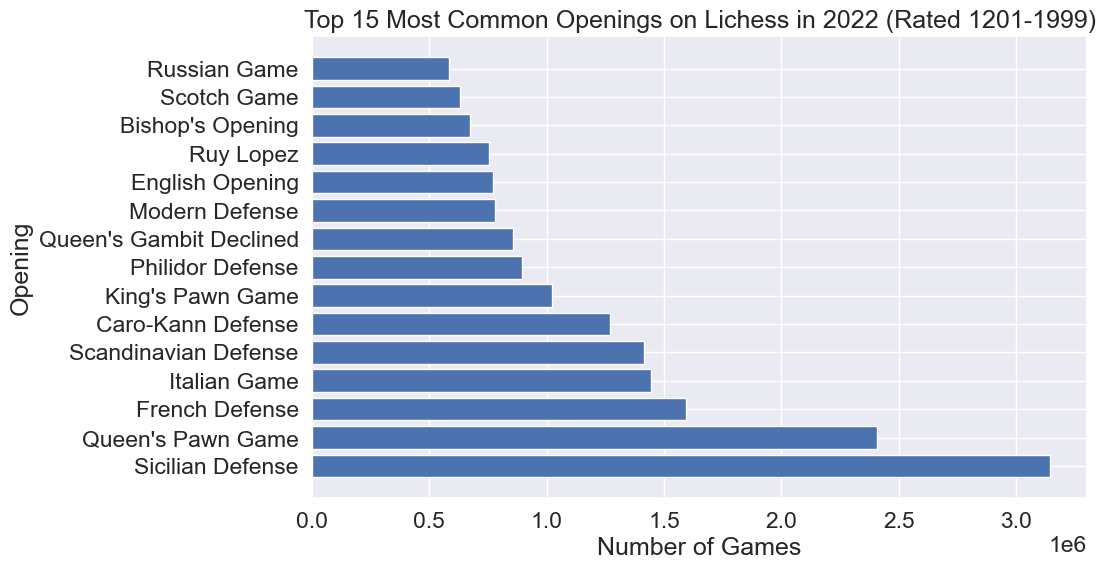

In [64]:
# Group variations of the same opening together by splitting on the colon.
mid_rated_opening_groups = (
    df[(df["WhiteElo"] >= 1201) & (df["WhiteElo"] <= 1999)]["Opening"]
    .str.split(":")
    .str[0]
    .value_counts()
    .compute()
)
display(mid_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
mid_rated_top_15_openings = mid_rated_opening_groups[:15]
mid_rated_top_15_openings_proportion = (
    mid_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 1201-1999 account for "
    f"{mid_rated_top_15_openings_proportion:.2%} of all games on Lichess in 2022."
)

# Plot the top 15 most common openings.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = mid_rated_opening_groups.index[:15]
values = mid_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 1201-1999)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Low Rated Players (Rating 1200 and Below)


Queen's Pawn Game                         586993
King's Pawn Game                          583240
Scandinavian Defense                      330632
Sicilian Defense                          267560
Italian Game                              258579
                                           ...  
Veresov Opening                                2
Colle System                                   2
Amar Gambit                                    1
Queen's Pawn Game, Zukertort Variation         1
Marienbad System                               1
Name: Opening, Length: 160, dtype: int64

The top 15 openings for players rated 1200 and below account for 8.95% of all games on Lichess in 2022.


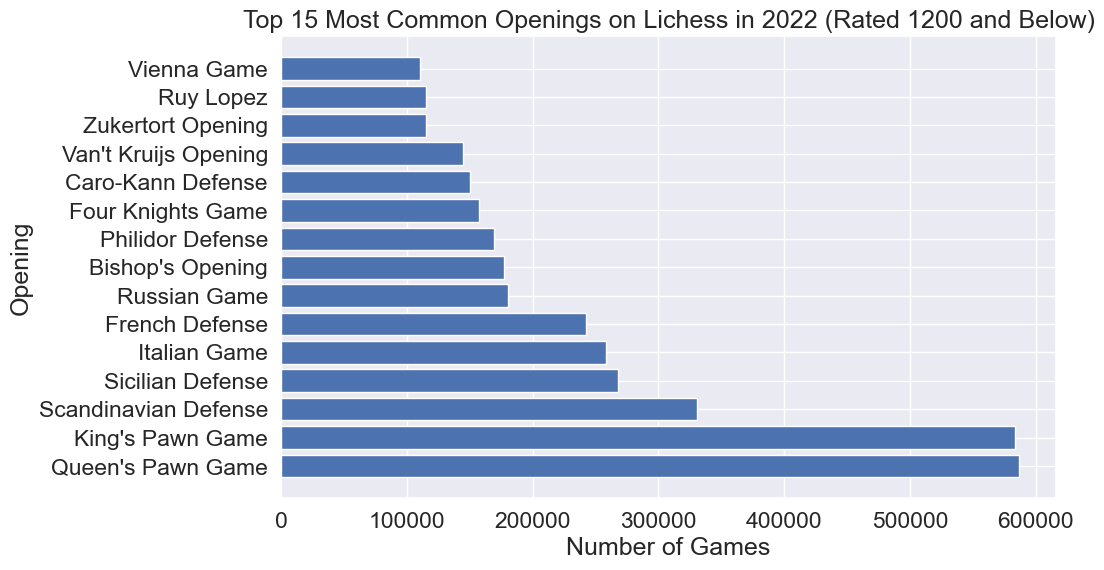

In [65]:
# Group variations of the same opening together by splitting on the colon.
low_rated_opening_groups = (
    df[df["WhiteElo"] <= 1200]["Opening"].str.split(":").str[0].value_counts().compute()
)
display(low_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
low_rated_top_15_openings = low_rated_opening_groups[:15]
low_rated_top_15_openings_proportion = (
    low_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 1200 and below account for "
    f"{low_rated_top_15_openings_proportion:.2%} of all games on Lichess in 2022."
)

# Plot the top 15 most common openings.
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = low_rated_opening_groups.index[:15]
values = low_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 1200 and Below)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


## Create Columns for Rating Differential


In [66]:
# Create an EloDiff column to represent the difference in Elo between the two
# players.
df["EloDiff"] = df["WhiteElo"] - df["BlackElo"]
# Calculate the relative rating difference of White to Black as a percentage.
# df["RelativeEloDiff"] = ((df["WhiteElo"] / df["BlackElo"] - 1.0) * 100.0).round(2)
df["RelativeEloDiff"] = (
    ((df["WhiteElo"] / (df[["WhiteElo", "BlackElo"]].median(axis=1))) - 1.0) * 100.0
).round(2)
display(df.head())


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site,EloDiff,RelativeEloDiff
0,2022-01-01 00:00:11,Rated Rapid game,600+0,1-0,Normal,B00,"Nimzowitsch Defense: Scandinavian Variation, A...",shahzad97,mpasha98,1500,1205,https://lichess.org/UMMGcaGz,295,10.91
1,2022-01-01 00:00:11,Rated Blitz game,300+3,0-1,Normal,D00,Queen's Pawn Game: Mason Variation,nicolas_clos,pangma,1430,1412,https://lichess.org/yJI78ET0,18,0.63
2,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,E97,"King's Indian Defense: Orthodox Variation, Aro...",oyuka79,JUAN121,2422,2292,https://lichess.org/mrPOJU0W,130,2.76
3,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,C22,Center Game: Berger Variation,manoharkatwa,RigoBam,1241,1221,https://lichess.org/YJ1AIn03,20,0.81
4,2022-01-01 00:00:12,Rated Blitz game,300+0,0-1,Time forfeit,A40,Modern Defense,raffrantic1,Carly001,1044,1091,https://lichess.org/RATgKCCm,-47,-2.20


### Effect of Higher Rating on White Win Rate


In [67]:
# Count the outcomes of all games.
outcomes = df["Result"].value_counts().compute()
print("Results of All Games:")
display(outcomes)
# Calculate how often White won and lost in all games.
num_white_wins = outcomes.loc["1-0"]
white_wins_proportion = num_white_wins / outcomes.sum()
num_white_losses = outcomes.loc["0-1"]
white_losses_proportion = num_white_losses / outcomes.sum()
print(
    f"Out of {outcomes.sum()} games:\n  White won {num_white_wins} games "
    f"({white_wins_proportion:.2%}).\n  White lost {num_white_losses} games "
    f"({white_losses_proportion:.2%})."
)

# Count the outcomes of games where White had a higher rating.
higher_white_outcomes = df[df["EloDiff"] > 0]["Result"].value_counts().compute()
print("\n\nResults of Games When White Had a Higher Rating:")
display(higher_white_outcomes)
# Calculate how often White won and lost when they had a higher rating.
num_higher_white_wins = higher_white_outcomes.loc["1-0"]
higher_white_wins_proportion = num_higher_white_wins / higher_white_outcomes.sum()
num_higher_white_losses = higher_white_outcomes.loc["0-1"]
higher_white_losses_proportion = num_higher_white_losses / higher_white_outcomes.sum()
print(
    f"Out of {higher_white_outcomes.sum()} games when White had a higher rating:\n  "
    f"White won {num_higher_white_wins} games ({higher_white_wins_proportion:.2%}).\n  "
    f"White lost {num_higher_white_losses} games ({higher_white_losses_proportion:.2%})."
)


Results of All Games:


1-0        19938052
0-1        18450502
1/2-1/2     1733174
Name: Result, dtype: int64

Out of 40121728 games:
  White won 19938052 games (49.69%).
  White lost 18450502 games (45.99%).


Results of Games When White Had a Higher Rating:


1-0        10662552
0-1         8242031
1/2-1/2      846503
Name: Result, dtype: int64

Out of 19751086 games when White had a higher rating:
  White won 10662552 games (53.98%).
  White lost 8242031 games (41.73%).


### Correlation Between Rating Difference and White Win Rate


In [68]:
# Count the different RelativeEloDiff values.
elo_diff_counts = df["EloDiff"].value_counts().compute()
# Get the minimum, maximum, mean, and median RelativeEloDiff values.
elo_diffs_min = np.min(elo_diff_counts.index)
elo_diffs_max = np.max(elo_diff_counts.index)
elo_diffs_mean = np.mean(elo_diff_counts.index)
elo_diffs_median = np.median(elo_diff_counts.index)
print(
    f"EloDiff:\n  Min: {elo_diffs_min}\n  "
    f"Max: {elo_diffs_max}\n  "
    f"Mean: {elo_diffs_mean:.2f}\n  "
    f"Median: {elo_diffs_median}"
)

# Bin the EloDiff values.
elo_diff_bins = np.arange(-2200, 2200, 100)
# Count the number of games in each bin.
elo_diff_counts.index = pd.cut(elo_diff_counts.index, bins=elo_diff_bins)
merged_elo_diff_counts = elo_diff_counts.groupby(level=0).sum()
print("\nNumber of Games in Each EloDiff Bin:")
display(merged_elo_diff_counts)


EloDiff:
  Min: -2106
  Max: 2106
  Mean: -4.37
  Median: -3.5

Number of Games in Each EloDiff Bin:


(-2200, -2100]           2
(-2100, -2000]           1
(-2000, -1900]           8
(-1900, -1800]          18
(-1800, -1700]          57
(-1700, -1600]          93
(-1600, -1500]         159
(-1500, -1400]         300
(-1400, -1300]         627
(-1300, -1200]        1017
(-1200, -1100]        1925
(-1100, -1000]        2729
(-1000, -900]         4399
(-900, -800]          7082
(-800, -700]         10925
(-700, -600]         16938
(-600, -500]         28098
(-500, -400]         85380
(-400, -300]        132263
(-300, -200]        222804
(-200, -100]       1688710
(-100, 0]         18167107
(0, 100]          17578324
(100, 200]         1654873
(200, 300]          226169
(300, 400]          132221
(400, 500]           85519
(500, 600]           27931
(600, 700]           17006
(700, 800]           10806
(800, 900]            7232
(900, 1000]           4323
(1000, 1100]          2735
(1100, 1200]          1745
(1200, 1300]           983
(1300, 1400]           609
(1400, 1500]           313
(

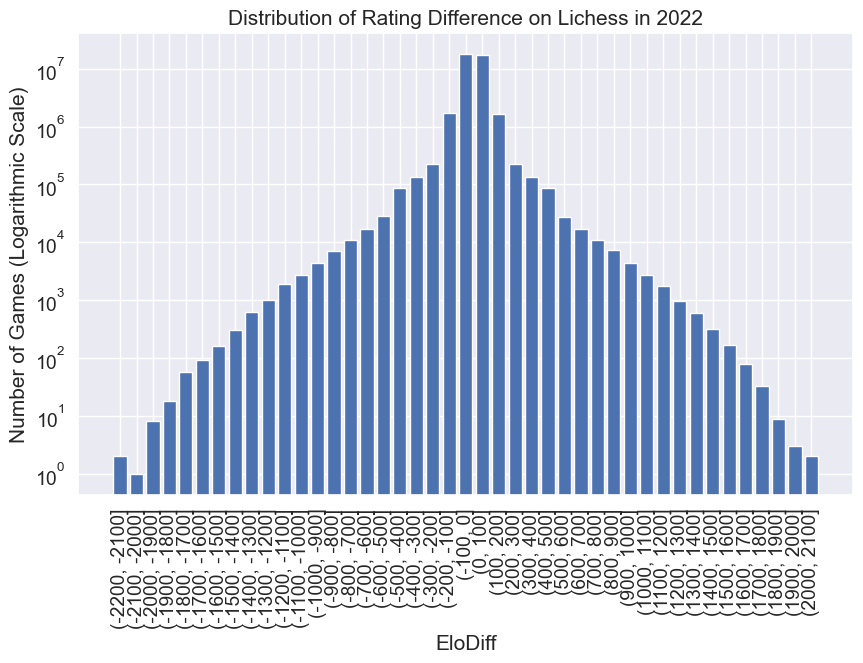

In [69]:
# Graph the number of games in each RelativeEloDiff bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = merged_elo_diff_counts.index.astype(str)
values = merged_elo_diff_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Rating Difference on Lichess in 2022")
ax.set_xlabel("EloDiff")
ax.set_ylabel("Number of Games (Logarithmic Scale)")
ax.set_yscale("log")
ax.set_xticklabels(indexes, rotation=90)
plt.show()


In [70]:
# Count the number of games where White won in each RelativeEloDiff bin.
elo_diff_wins = df[df["Result"] == "1-0"]["EloDiff"].value_counts().compute()
elo_diff_wins.index = pd.cut(elo_diff_wins.index, bins=elo_diff_bins)
merged_elo_diff_wins = elo_diff_wins.groupby(level=0).sum()
print("Number of Games Where White Won in Each RelativeEloDiff Bin:")
display(merged_elo_diff_wins)


Number of Games Where White Won in Each RelativeEloDiff Bin:


(-2200, -2100]          0
(-2100, -2000]          0
(-2000, -1900]          1
(-1900, -1800]          0
(-1800, -1700]         12
(-1700, -1600]         11
(-1600, -1500]         24
(-1500, -1400]         35
(-1400, -1300]         45
(-1300, -1200]         88
(-1200, -1100]        207
(-1100, -1000]        307
(-1000, -900]         516
(-900, -800]         1001
(-800, -700]         1572
(-700, -600]         2734
(-600, -500]         5005
(-500, -400]        14318
(-400, -300]        27434
(-300, -200]        59932
(-200, -100]       627715
(-100, 0]         8534543
(0, 100]          9247346
(100, 200]        1023192
(200, 300]         160227
(300, 400]         102045
(400, 500]          69540
(500, 600]          22236
(600, 700]          13683
(700, 800]           8843
(800, 900]           6051
(900, 1000]          3630
(1000, 1100]         2333
(1100, 1200]         1522
(1200, 1300]          852
(1300, 1400]          551
(1400, 1500]          257
(1500, 1600]          140
(1600, 1700]

Win Rate (%) for White in Each EloDiff Bin:


(-2200, -2100]      0.00
(-2100, -2000]      0.00
(-2000, -1900]     12.50
(-1900, -1800]      0.00
(-1800, -1700]     21.05
(-1700, -1600]     11.83
(-1600, -1500]     15.09
(-1500, -1400]     11.67
(-1400, -1300]      7.18
(-1300, -1200]      8.65
(-1200, -1100]     10.75
(-1100, -1000]     11.25
(-1000, -900]      11.73
(-900, -800]       14.13
(-800, -700]       14.39
(-700, -600]       16.14
(-600, -500]       17.81
(-500, -400]       16.77
(-400, -300]       20.74
(-300, -200]       26.90
(-200, -100]       37.17
(-100, 0]          46.98
(0, 100]           52.61
(100, 200]         61.83
(200, 300]         70.84
(300, 400]         77.18
(400, 500]         81.32
(500, 600]         79.61
(600, 700]         80.46
(700, 800]         81.83
(800, 900]         83.67
(900, 1000]        83.97
(1000, 1100]       85.30
(1100, 1200]       87.22
(1200, 1300]       86.67
(1300, 1400]       90.48
(1400, 1500]       82.11
(1500, 1600]       81.87
(1600, 1700]       82.05
(1700, 1800]       84.85


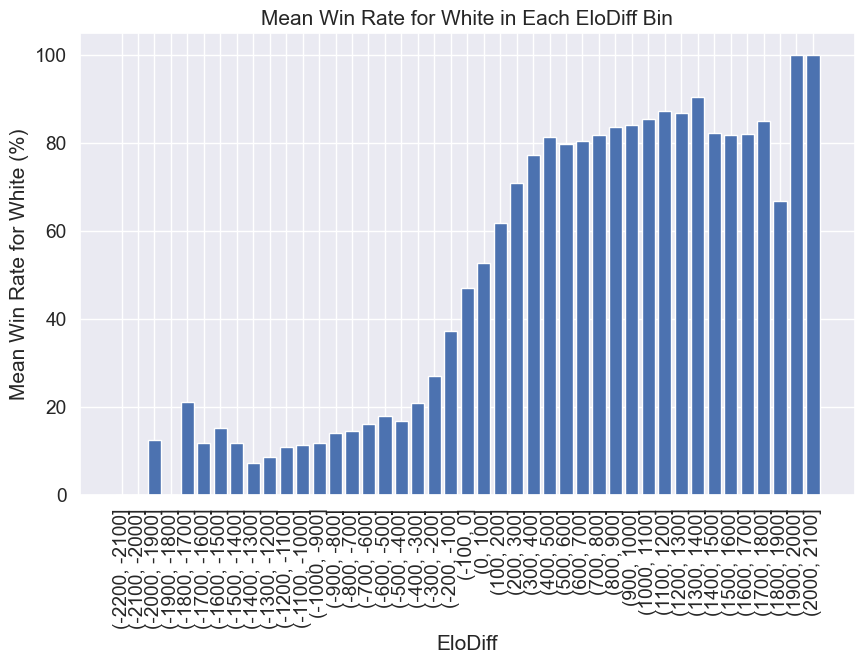

In [71]:
# Calculate the proportion of games where White won in each RelativeEloDiff bin.
merged_elo_diff_win_rates = (
    (merged_elo_diff_wins / merged_elo_diff_counts) * 100.0
).round(2)
print("Win Rate (%) for White in Each EloDiff Bin:")
display(merged_elo_diff_win_rates)

# Plot the mean win rate for White in each RelativeEloDiff bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the mean win rate for White in each RelativeEloDiff bin.
indexes = merged_elo_diff_win_rates.index.astype(str)
values = merged_elo_diff_win_rates.values
ax.bar(indexes, values)
ax.set_title("Mean Win Rate for White in Each EloDiff Bin")
ax.set_xlabel("EloDiff")
ax.set_ylabel("Mean Win Rate for White (%)")
ax.set_xticklabels(indexes, rotation=90)
plt.show()


### Correlation Between Relative Rating Difference and White Win Rate


In [72]:
# Count the different RelativeEloDiff values.
relative_elo_diff_counts = df["RelativeEloDiff"].value_counts().compute()
# Get the minimum, maximum, mean, and median RelativeEloDiff values.
relative_elo_diffs_min = np.min(relative_elo_diff_counts.index)
relative_elo_diffs_max = np.max(relative_elo_diff_counts.index)
relative_elo_diffs_mean = np.mean(relative_elo_diff_counts.index)
relative_elo_diffs_median = np.median(relative_elo_diff_counts.index)
print(
    f"RelativeEloDiff:\n  Min: {relative_elo_diffs_min}\n  "
    f"Max: {relative_elo_diffs_max}\n  "
    f"Mean: {relative_elo_diffs_mean:.2f}\n  "
    f"Median: {relative_elo_diffs_median}"
)

# Bin the RelativeEloDiff values.
elo_diff_bins = np.arange(-60, 60, 10)
# Count the number of games in each bin.
relative_elo_diff_counts.index = pd.cut(
    relative_elo_diff_counts.index, bins=elo_diff_bins
)
merged_relative_elo_diff_counts = relative_elo_diff_counts.groupby(level=0).sum()
print("\nNumber of Games in Each RelativeEloDiff Bin:")
display(merged_relative_elo_diff_counts)


RelativeEloDiff:
  Min: -62.59
  Max: 62.89
  Mean: -0.13
  Median: -0.14500000000000002

Number of Games in Each RelativeEloDiff Bin:


(-60, -50]         500
(-50, -40]        2773
(-40, -30]       10269
(-30, -20]       39507
(-20, -10]      238650
(-10, 0]      20078939
(0, 10]       19456414
(10, 20]        241485
(20, 30]         39591
(30, 40]         10369
(40, 50]          2753
Name: RelativeEloDiff, dtype: int64

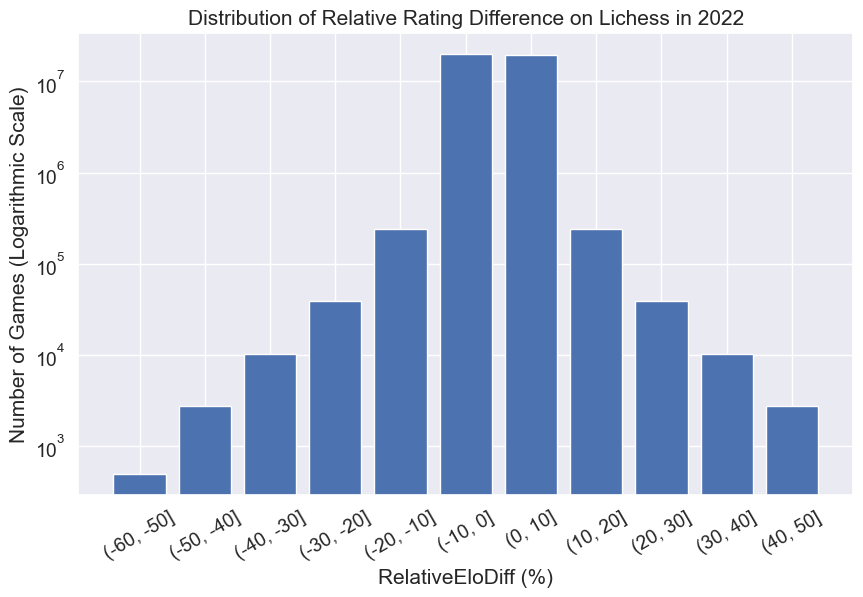

In [73]:
# Graph the number of games in each RelativeEloDiff bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
indexes = merged_relative_elo_diff_counts.index.astype(str)
values = merged_relative_elo_diff_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Relative Rating Difference on Lichess in 2022")
ax.set_xlabel("RelativeEloDiff (%)")
ax.set_ylabel("Number of Games (Logarithmic Scale)")
ax.set_yscale("log")
ax.set_xticklabels(indexes, rotation=30)
plt.show()


In [74]:
# Count the number of games where White won in each RelativeEloDiff bin.
relative_elo_diff_wins = (
    df[df["Result"] == "1-0"]["RelativeEloDiff"].value_counts().compute()
)
relative_elo_diff_wins.index = pd.cut(relative_elo_diff_wins.index, bins=elo_diff_bins)
merged_relative_elo_diff_wins = relative_elo_diff_wins.groupby(level=0).sum()
print("Number of Games Where White Won in Each RelativeEloDiff Bin:")
display(merged_relative_elo_diff_wins)


Number of Games Where White Won in Each RelativeEloDiff Bin:


(-60, -50]          63
(-50, -40]         309
(-40, -30]        1323
(-30, -20]        6363
(-20, -10]       49263
(-10, 0]       9218179
(0, 10]       10432625
(10, 20]        186534
(20, 30]         31935
(30, 40]          8683
(40, 50]          2369
Name: RelativeEloDiff, dtype: int64

Win Rate (%) for White in Each RelativeEloDiff Bin:


(-60, -50]    12.60
(-50, -40]    11.14
(-40, -30]    12.88
(-30, -20]    16.11
(-20, -10]    20.64
(-10, 0]      45.91
(0, 10]       53.62
(10, 20]      77.24
(20, 30]      80.66
(30, 40]      83.74
(40, 50]      86.05
Name: RelativeEloDiff, dtype: float64

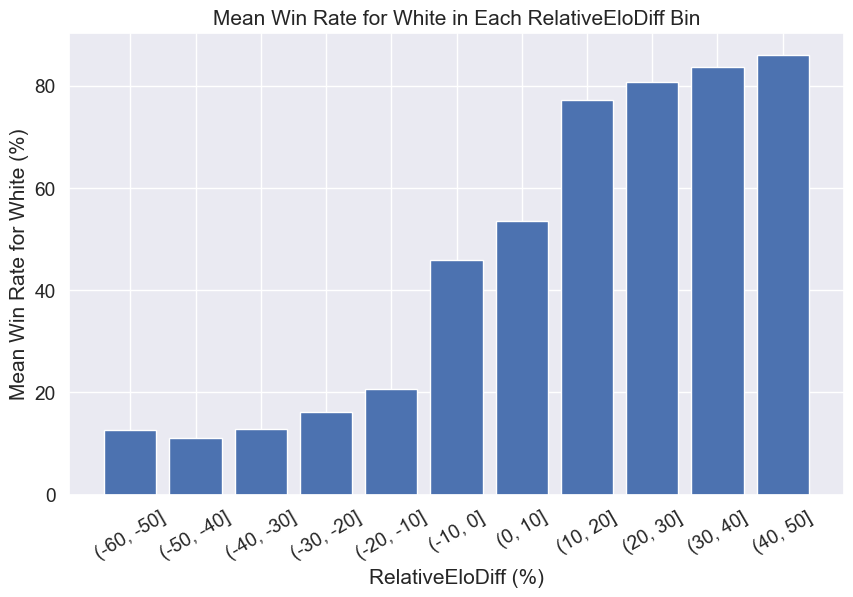

In [75]:
# Calculate the proportion of games where White won in each RelativeEloDiff bin.
merged_relative_elo_diff_win_rates = (
    (merged_relative_elo_diff_wins / merged_relative_elo_diff_counts) * 100.0
).round(2)
print("Win Rate (%) for White in Each RelativeEloDiff Bin:")
display(merged_relative_elo_diff_win_rates)

# Plot the mean win rate for White in each RelativeEloDiff bin.
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the mean win rate for White in each RelativeEloDiff bin.
indexes = merged_relative_elo_diff_win_rates.index.astype(str)
values = merged_relative_elo_diff_win_rates.values
ax.bar(indexes, values)
ax.set_title("Mean Win Rate for White in Each RelativeEloDiff Bin")
ax.set_xlabel("RelativeEloDiff (%)")
ax.set_ylabel("Mean Win Rate for White (%)")
ax.set_xticklabels(indexes, rotation=30)
plt.show()
